# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import math

### Exercise 07.1
In the MD/MC code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

### Exercise 07.2

Use the MD/MC code to <span style="color:red">print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations</span> (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. <span style="color:red">Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.

In [24]:
epot_ist_s = np.loadtxt("epot_ist_solid.out")
epot_ist_l = np.loadtxt("epot_ist_liquid.out")
epot_ist_g = np.loadtxt("epot_ist_gas.out")

step=0.12
npoints_s = len(epot_ist_s)
npoints_l = len(epot_ist_l)
npoints_g = len(epot_ist_g)

t_s = np.linspace(1, npoints_s, num=npoints_s)
t_l = np.linspace(1, npoints_l, num=npoints_l)
t_g = np.linspace(1, npoints_g, num=npoints_g)

#plt.plot(t_s, epot_ist_s)
#plt.xlabel('# steps')
#plt.ylabel('U/N')
#plt.title('time series: solid')
#plt.show()

#plt.plot(t_l, epot_ist_l)
#plt.xlabel('# steps')
#plt.ylabel('U/N')
#plt.title('time series: liquid')
#plt.show()

#plt.plot(t_g, epot_ist_g)
#plt.xlabel('# steps')
#plt.ylabel('U/N')
#plt.title('time series: gas')
#plt.show()

Equilibration steps required:
- solid: 1000
- liquid: 2000
- gas: 15000

Metropolis step chosen to have an acceptance ratio $\simeq 0.5$:
- solid: 0.1
- liquid: 0.2
- gas: 8

Since we are dealing with a very long time series ($M = 10000$), calculating the autocorrelation function through its definition is computationally inefficient. Instead of doing so, we exploit a trick. It can be shown that the power spectral density of the time series $X(t)$ is proportional to the square of the Fourier transform of the series:
$$S_{[X]}(\omega) = \lim_{T\to\infty} \frac{|X_T(\omega)|^2}{T}$$

The power specral density is in turn the Fourier transform of the autocorrelation function:

$$S_{[X]}(\omega) = \int_{-\infty}^{+\infty}d\tau e^{i\omega\tau}Ac_{[X]}(\tau)$$

Adding all up, the autocorrelation function of $U/N$ is best calculated by taking the Fourier tranform of the time series (after subtracting ts mean), squaring it, taking the antitrasform of the result and normalizing it dividing by the time interval. The Fourier (anti)transforms are computed exploiting the FFT (fast Fourier transorm) algorithm from the numpy library.

threshold: 0.0001
estimated autocorrelation time: 74


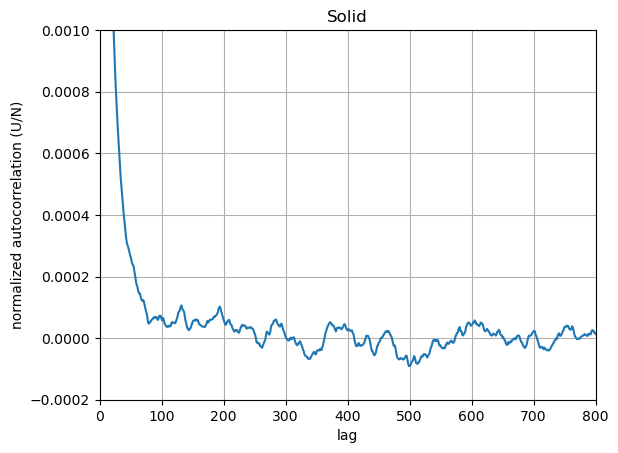

threshold: 0.0001
estimated autocorrelation time: 167


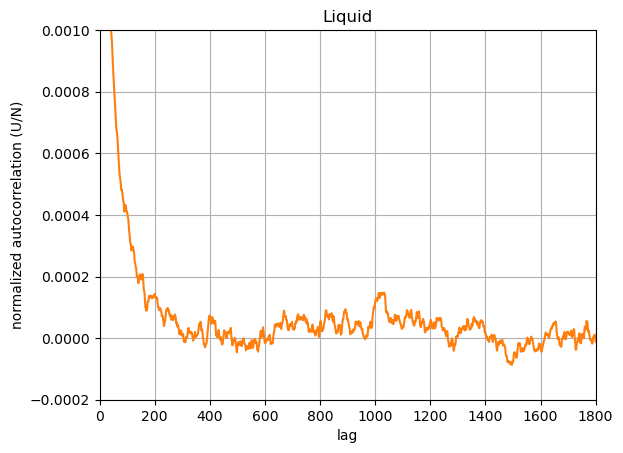

threshold: 0.0001
estimated autocorrelation time: 10


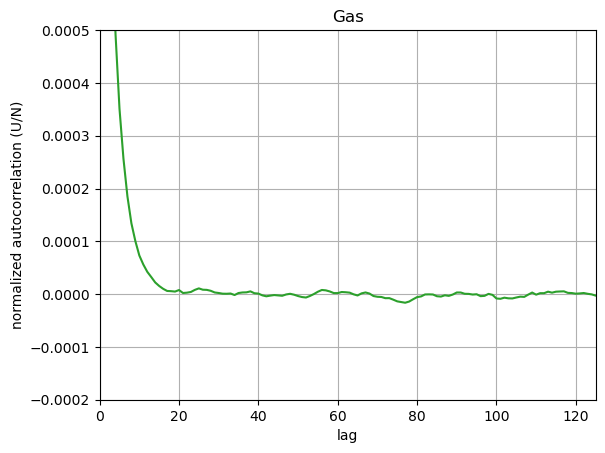

In [25]:
def autocorr_fft(x):
    # Compute autocorrelation using FFT
    x = x - np.mean(x)
    f = np.fft.fft(x)
    acf = np.real(np.fft.ifft(f * np.conj(f)))
    #multiplies the Fourier coefficients by their complex conjugates,
    #takes the inverse Fourier transform of the result, and takes the real part of the output.
    #The resulting array acf contains the values of the autocorrelation function at each lag.
    acf /= len(x)   #Normalization
    return acf[:len(x)//2]

def autocorr_time(x, threshold):
    acf = autocorr_fft(x)
    for i in range(1, len(acf)):
        if acf[i] < threshold:
            return i
    return len(acf)-1

def plot_autocorr(data, name, colour, maxlag, minauto, maxauto):
    # Compute the autocorrelation function using FFT
    autocorr = autocorr_fft(data)

    # Plot the autocorrelation function
    plt.plot(autocorr, color=f'{colour}')
    plt.xlabel('lag')
    plt.ylabel('normalized autocorrelation (U/N)')
    plt.title(f'{name}')
    plt.grid(True)
    ax = plt.gca()
    ax.set_xlim([0, maxlag])
    ax.set_ylim([minauto, maxauto])
    
    threshold=0.0001
    tau = autocorr_time(data, threshold)
    print(f"threshold: {threshold}")
    print(f"estimated autocorrelation time: {tau}")
    plt.show()
    
plot_autocorr(epot_ist_s, 'Solid', 'C0', 800, -0.0002, 0.001)
plot_autocorr(epot_ist_l, 'Liquid', 'C1', 1800, -0.0002, 0.001)
plot_autocorr(epot_ist_g, 'Gas', 'C2', 125, -0.0002, 0.0005)

2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. <span style="color:red">Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

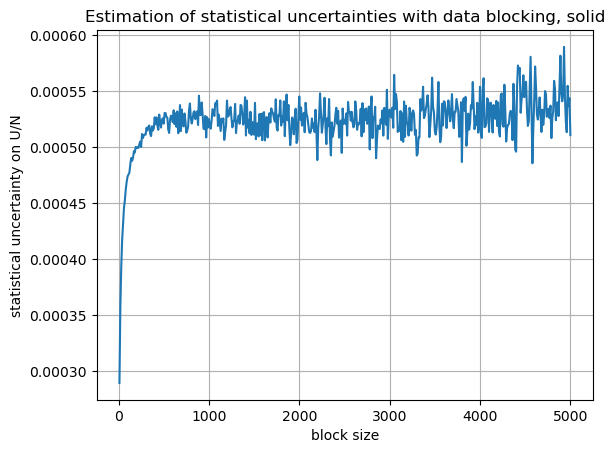

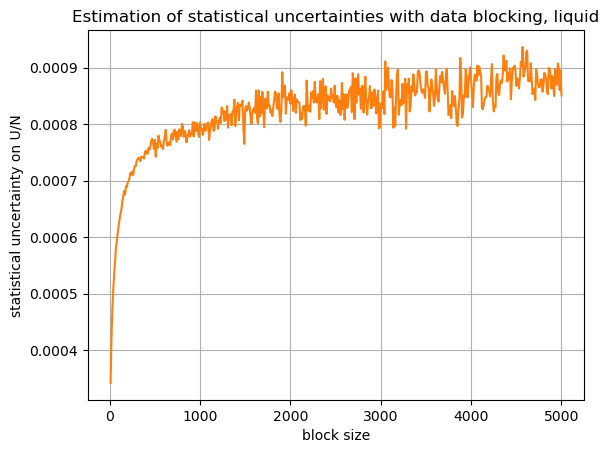

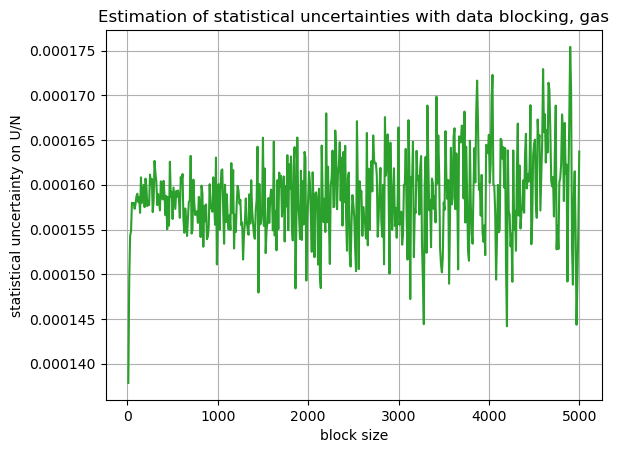

In [26]:
blk_sizes = np.arange(10, 5001, 10)

def rms_blockav(X, blk_size):
    nblks = len(X)//blk_size
    blkav = np.zeros(nblks)
    
    for iblk in range(0, nblks):
        blkav[iblk] = np.mean(X[iblk*blk_size:(iblk+1)*blk_size]) 
    
    return np.sqrt(np.mean(blkav**2) - (np.mean(blkav))**2) / np.sqrt(nblks-1)


blk_errors_s = []
blk_errors_l = []
blk_errors_g = []
for size in blk_sizes:
    blk_errors_s.append(rms_blockav(epot_ist_s, size))
    blk_errors_l.append(rms_blockav(epot_ist_l, size))
    blk_errors_g.append(rms_blockav(epot_ist_g, size))

    
def plot_errors(errors, colour, phase):
    plt.plot(blk_sizes, errors, color=f'{colour}')
    plt.xlabel('block size')
    plt.ylabel('statistical uncertainty on U/N')
    plt.title(f'Estimation of statistical uncertainties with data blocking, {phase}')
    plt.grid(True)
    plt.show()


plot_errors(blk_errors_s, 'C0', 'solid')
plot_errors(blk_errors_l, 'C1', 'liquid')
plot_errors(blk_errors_g, 'C2', 'gas')

### Comments

When using the data blocking technique, it is important that the averages within different blocks are not correlated. Infact only in this case the hypotheses of the central limit theorem hold and the average among blocks and the standard deviation of the mean can be provided as a good estimation for observables. </p>

After a steep increase, the statistical uncertainty on $U/N$ as a function of the block size saturates around a maximum value. This happens because on one hand the distribution of the block averages becomes narrower, on the other hand (if the total number of points is conserved) the number of blocks, which is in the denominator of the standard deviation of the mean, becomes smaller, canceling out the other effect. Anyway, as shown in the graphs, the statistical uncertainty oscillates more as the block size increases, suggesting that the safest choice for the block length is that of a couple of correlation times. 

### Exercise 07.3

<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the MD/MC code</span>: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

### Exercise 07.4

By means of your upgraded MD/MC code, equilibrate and <span style="color:red">perform MC NVT simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... <span style="color:red"> and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.</span>

In [27]:
def plot_prop(data1, data2, phase, prop, prop_y, nsteps=2000):
    blks1 = data1[:, 0]
    av1 = data1[:, 2]
    err1 = data1[:, 3]
    blks2 = data2[:, 0]
    av2 = data2[:, 2]
    err2 = data2[:, 3]
    
    plt.errorbar(blks1*nsteps, av1, yerr=err1, label='MD')
    plt.errorbar(blks2*nsteps, av2, yerr=err2, label='MC')
    plt.xlabel('#steps')
    plt.ylabel(f'{prop_y}')
    plt.title(f'{prop}, {phase}')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    return
    
def plot_g(data1, data2, phase):
    r1 = data1[:, 0]
    gofr1 = data1[:, 2]
    err1 = data1[:, 3]
    r2 = data2[:, 0]
    gofr2 = data2[:, 2]
    err2 = data2[:, 3]
    
    plt.errorbar(r1, gofr1, yerr=err1, label='MD')
    plt.errorbar(r2, gofr2, yerr=err2, label='MC')
    plt.xlabel('r')
    plt.ylabel('g(r)')
    plt.title(f'Radial distribution function, {phase}')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    return

### Solid phase

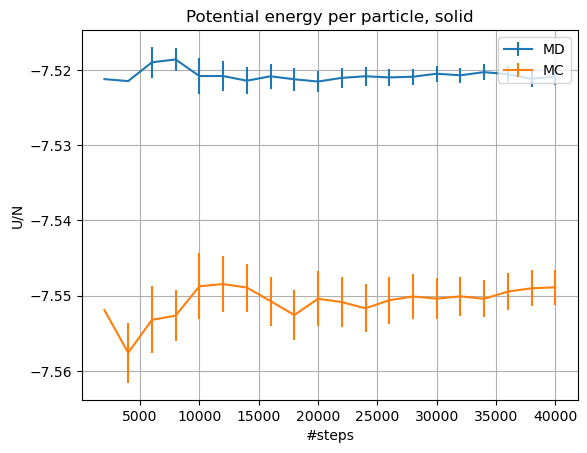

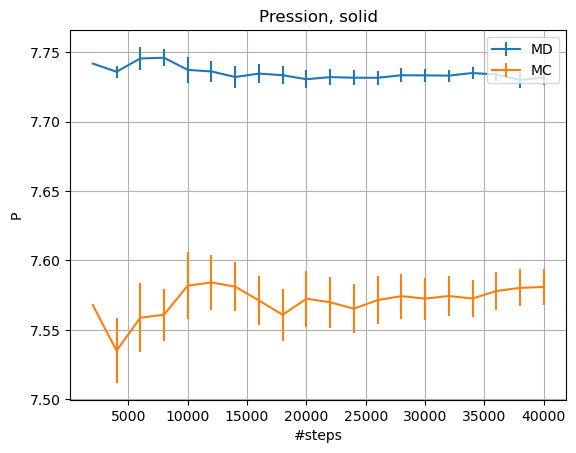

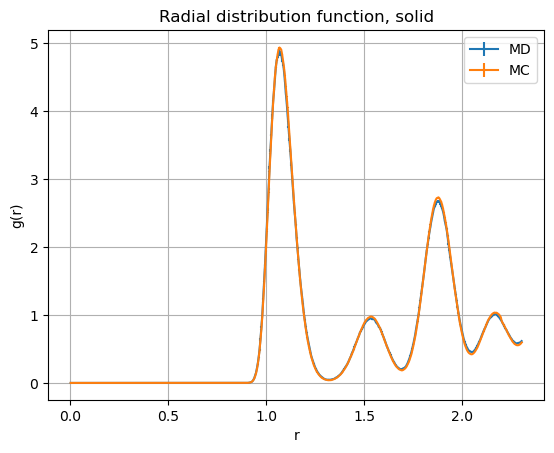

In [28]:
epot_s_MD = np.loadtxt('epot_solid_MD.out')
epot_s_MC = np.loadtxt('epot_solid_MC.out')
press_s_MD = np.loadtxt('press_solid_MD.out')
press_s_MC = np.loadtxt('press_solid_MC.out')
gofr_s_MD = np.loadtxt('gofr_solid_MD.out')
gofr_s_MC = np.loadtxt('gofr_solid_MC.out')

plot_prop(epot_s_MD, epot_s_MC, 'solid', 'Potential energy per particle', 'U/N')
plot_prop(press_s_MD, press_s_MC, 'solid', 'Pression', 'P')
plot_g(gofr_s_MD, gofr_s_MC, 'solid')

### Liquid phase

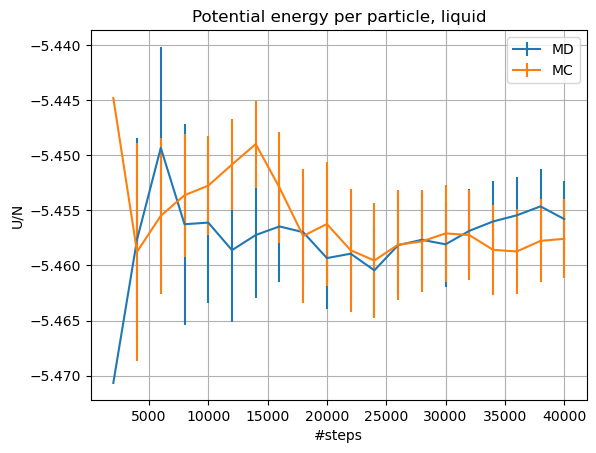

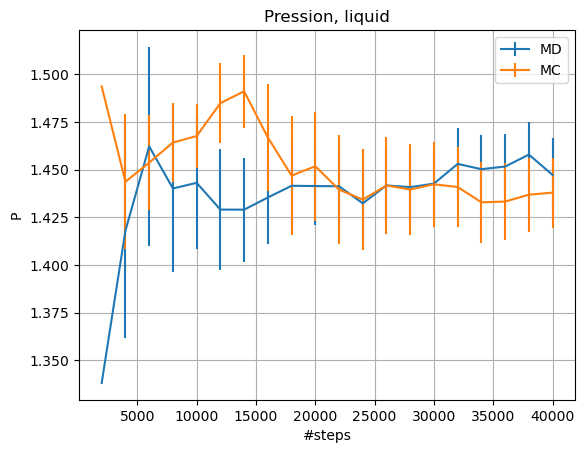

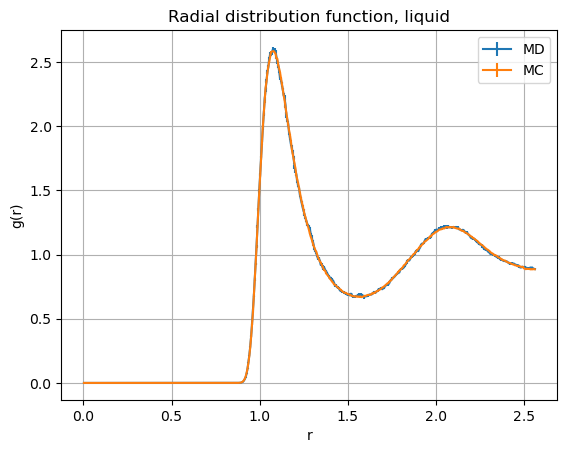

In [29]:
epot_l_MD = np.loadtxt('epot_liquid_MD.out')
epot_l_MC = np.loadtxt('epot_liquid_MC.out')
press_l_MD = np.loadtxt('press_liquid_MD.out')
press_l_MC = np.loadtxt('press_liquid_MC.out')
gofr_l_MD = np.loadtxt('gofr_liquid_MD.out')
gofr_l_MC = np.loadtxt('gofr_liquid_MC.out')

plot_prop(epot_l_MD, epot_l_MC, 'liquid', 'Potential energy per particle', 'U/N')
plot_prop(press_l_MD, press_l_MC, 'liquid', 'Pression', 'P')
plot_g(gofr_l_MD, gofr_l_MC, 'liquid')

### Gas phase

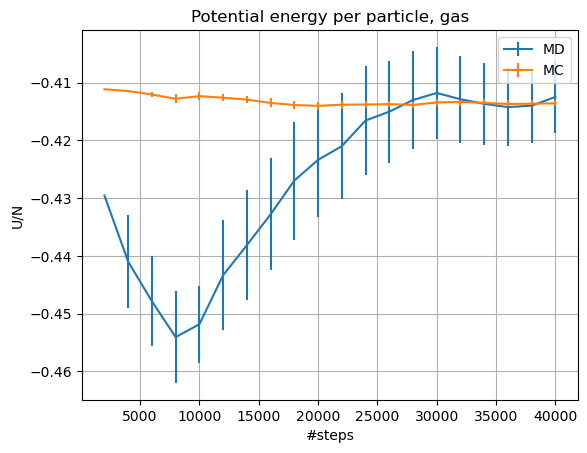

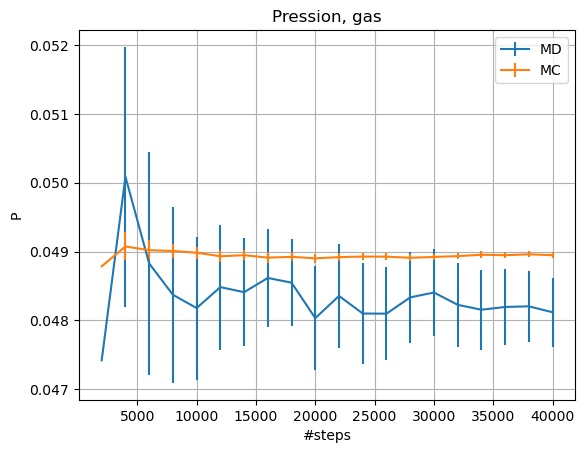

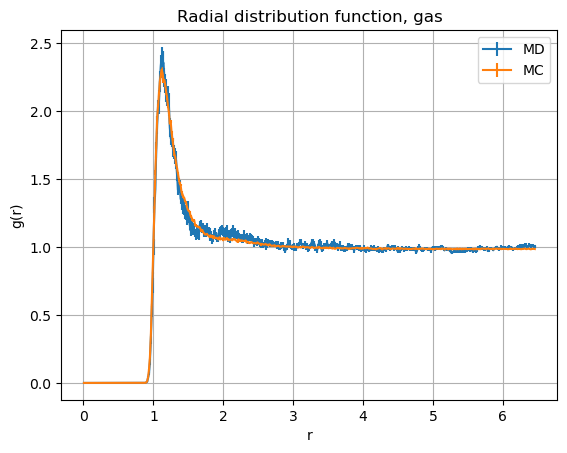

In [30]:
epot_g_MD = np.loadtxt('epot_gas_MD.out')
epot_g_MC = np.loadtxt('epot_gas_MC.out')
press_g_MD = np.loadtxt('press_gas_MD.out')
press_g_MC = np.loadtxt('press_gas_MC.out')
gofr_g_MD = np.loadtxt('gofr_gas_MD.out')
gofr_g_MC = np.loadtxt('gofr_gas_MC.out')

plot_prop(epot_g_MD, epot_g_MC, 'gas', 'Potential energy per particle', 'U/N')
plot_prop(press_g_MD, press_g_MC, 'gas', 'Pression', 'P')
plot_g(gofr_g_MD, gofr_g_MC, 'gas')

### Final remarks
The predictions of the Molecular Dynamics (MD) algorithm and the Monte Carlo algorithm (MC) for the liquid and the gas phase are in fair statistical agreement with each other. This is not exactly the case for the solid. However, the result is still acceptable if we consider the core differences between the two algorithms. </p>

When performing a MD simulation, the number of particles ($N$) and the density ($\rho$), thus the volume ($V$) are fixed. Although the temperature too is given as an input in the simulation, it is not conserved. This beacause the integration algorithms employed (e. g. the Verlet algorithm) conserve energy, leading to a runtime exchange of potential and kinetic energy that results in a temperature change. For this reason MD is adapted to the microcanonical ensamble: $N$, $V$, $E$ are conserved. In contrast, in MC simulation the Metropolis algorithm is used to sample from the Maxwell-Boltzmann distribution. Since the weights depend on temperature ($T$), temperature is conserved. Also $N$ and $V$ are conserved. This is why MC simulations are adapted to the canonical ensemble. </p>

Despite this difference, if we are able to control in some way the final temperature of MD simulations and reach equilibrium, we can compare the result with MC, emphasizing the effectiveness of statistical mechanics. 